In [34]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.model_selection import train_test_split
#import torch.nn.functional as F

In [35]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def fLR(w, x, y):
    h = sigmoid(x @ w)
    eps = 1e-4
    return (- y @ np.log(h + eps) - (1 - y) @ np.log(1 - h + eps)) / y.shape[0]

def dfLR(w, x, y):
    h = sigmoid(x @ w)
    return x.T @ (h - y) / y.shape[0]

def d2fLR(w, x, y):
    h = sigmoid(x @ w)
    return (x.T * (h * (1 - h))) @ x / y.shape[0]

def fInner(w, lam, x, y):
    return fLR(w, x, y) + w @ (lam * w)

def dfInner(w, lam, x, y):
    # d/dw
    return dfLR(w, x, y) + 2 * lam * w

def d2fInner(w, lam, x, y):
    # d2/dw2, d2/dwdlam
    return d2fLR(w, x, y) + 2 * np.diag(lam), 2 * np.diag(w)

In [36]:
def fOuter(w, x, y):
    return fLR(w, x, y)

def dfOuter(w, x, y):
    return dfLR(w, x, y)

In [37]:
from sklearn.datasets import load_svmlight_file
x, y = load_svmlight_file("covtype.libsvm.binary.scale.bz2")
x = x.toarray()
y = y - 1
print(y)

[0. 0. 1. ... 0. 0. 0.]


In [38]:
# synthetic data generation
seed = 2021
val_perc = 0.2
np.random.seed(seed)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_perc)
d = x_train.shape[1]
print(x_train.shape)
print(x_val.shape)
print(d)

(464809, 54)
(116203, 54)
54


In [39]:
# hyper parameters
epochmax = 10
bs = 50
itermax = x_train.shape[0] // bs
lr_in = 0.1
lr_out = 0.1
tau = 0.1


# initial parameters
seed = 1234
w0 = np.random.randn(d)
lam0 = np.ones(d) # np.zeros(d) #
H1 = np.identity(d)
H2 = np.zeros((d, d))
L_g = 0.5 * np.linalg.eigvals((x_train.T @ x_train)).max() / x_train.shape[0] + 2# * lam0.max()
print(L_g)

3.570567599224631


In [40]:
np.random.seed(seed)
record_loss = []
w = w0
lam = lam0
for epoch in range(epochmax):
    for i in range(itermax):
        #s = idx[i * bs : (i+1) * bs]
        s = np.random.choice(x_train.shape[0], size=bs)
        w = w - lr_in * dfInner(w, lam, x_train[s,:], y_train[s])
    
    record_loss.append(fOuter(w, x_val, y_val))
    
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6906419322515241
0.6925928388696563


In [41]:
record_loss_our = []
record_s_our = []
record_t_our = []
w = w0
lam = lam0
tau = 0.1
H1 = np.identity(d) 
H2 = np.zeros((d, d))

In [42]:
def my_solve(H, v): # solve Hw = v for w
    c = 0.9/L_g#H.diagonal().max()#np.linalg.eigvalsh(H).max()#0.5/L_g
    w = np.copy(v)
    for _ in range(5):
        v = v - c * H @ v
        w += v    
    return c*w
#def my_solve(H, v):
#    return np.linalg.solve(H, v)

In [43]:
# STABLE no tracking
num_s = 0
np.random.seed(seed)
t_start = time.time()
for epoch in range(epochmax):
    for i in range(itermax):  
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        lam = lam + lr_out * H2 @ my_solve(H1, dfOuter(w, x_val[s,:], y_val[s]))
        lam -= 1e-4
        lam = lam * (lam > 0.).astype(float)
        lam += 1e-4
        
        # inner loop
        w_p = w
        w = w - lr_in * dfInner(w, lam_p, x_train[s,:], y_train[s]) - my_solve(H1, (H2.T @ (lam - lam_p)))
    
        # update H1, H2
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        
        h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
        #h1_p, _ = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        #_, h2_p = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        H1 = h1#(1 - tau) * (H1 - h1_p) + h1
        H2 = h2#(1 - tau) * (H2 - h2_p) + h2
        
        record_loss_our.append(fOuter(w, x_val, y_val))
        record_s_our.append(num_s)
        record_t_our.append(time.time()-t_start)
    
    #eigs, eigv = np.linalg.eigh(H1)
    #eigs = np.maximum(eigs, 1e-4)
    #H1 = eigv @ (eigs[:, np.newaxis] * eigv.T)  
    #H2 = np.maximum(np.minimum(H2, 1), -1)
    
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6054760753794142
0.6236817739645333


In [12]:
print(np.linalg.eigvalsh(H1).max())
print(L_g)

2.691786851316123
3.570567599224631


In [46]:
# hong increasing batch size
record_loss_hong = []
record_s = []
record_t_hong = []
w = w0
lam = lam0
num_s = 0
np.random.seed(seed)
t_start = time.time()
for epoch in range(epochmax):
    for i in range(itermax): 
        # inner loop
        w_p = w
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        w = w - (lr_in * (epoch + 1)**(0)) * dfInner(w, lam, x_train[s,:], y_train[s])#-2/5
   
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        t = int(np.log(epoch * itermax + i + 1)) + 1
        p = np.random.randint(t)
        num_s += p * bs
        hg = dfOuter(w, x_val[s,:], y_val[s])
        for j in range(p):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
        hg = hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        lam -= 1e-4
        lam = lam * (lam > 0.).astype(float)
        lam += 1e-4
         
        record_s.append(num_s)    
        record_loss_hong.append(fOuter(w, x_val, y_val))
        record_t_hong.append(time.time()-t_start)
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6099191896563003
0.6263668524160139


In [48]:
# wang increasing batch size
record_loss_wang = []
record_s_wang = []
record_t_wang = []
w = w0
lam = lam0
num_s = 0
np.random.seed(seed)
t_start = time.time()
for epoch in range(epochmax//2):
    for i in range(itermax): 
        # inner loop
        for t in range(np.int(np.sqrt(epoch * itermax + i + 1))):
            w_p = w
            s = np.random.choice(x_train.shape[0], size=bs)
            w = w - (lr_in * (epoch + 1)**(0)) * dfInner(w, lam, x_train[s,:], y_train[s])#-2/5
        num_s += bs * (t+1)
        
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        t = np.int((np.log(epoch * itermax + i + 1))) + 1
        p = np.random.randint(t)
        num_s += p * bs
        hg = dfOuter(w, x_val[s,:], y_val[s])
        for j in range(p):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
        hg = hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        lam -= 1e-4
        lam = lam * (lam > 0.).astype(float)
        lam += 1e-4
    
        record_s_wang.append(num_s)    
        record_loss_wang.append(fOuter(w, x_val, y_val))
        record_t_wang.append(time.time()-t_start)
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6323377014121707
0.6413554380051637


In [49]:
# stocBio
record_loss_stocbio = []
record_s_stocbio = []
record_t_stocbio = []
w = w0
lam = lam0
np.random.seed(seed)
T = 5
bs = 500
itermax = x_train.shape[0] // bs
num_s = 0
t_start = time.time()
for epoch in range(epochmax):
    for i in range(itermax):
        # inner loop
        for t in range(T):
            s = np.random.choice(x_train.shape[0], size=bs)
            num_s += bs
            w = w - lr_in * dfInner(w, lam, x_train[s,:], y_train[s]) * 5
        # outer loop
        lam_p = lam
        Q = int(np.log(epoch*itermax + i + 1)) + 1
        num_s += Q * bs
        s = np.random.choice(x_val.shape[0], size=bs)
        hg = dfOuter(w, x_val[s,:], y_val[s])
        vQ = np.copy(hg)
        eta = 0.5/L_g
        for j in range(Q):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - eta * (h1 @ hg)
            vQ += hg
        hg = vQ * eta#hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg * 5
        
        lam -= 1e-4
        lam = lam * (lam > 0.).astype(float)
        lam += 1e-4
    
        record_s_stocbio.append(num_s)    
        record_loss_stocbio.append(fOuter(w, x_val, y_val))
        record_t_stocbio.append(time.time()-t_start)
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6169674990841171
0.6253863428266321


In [50]:
np.savetxt('./results_covtype/record_loss_our', record_loss_our)
np.savetxt('./results_covtype/record_s_our', record_s_our)
np.savetxt('./results_covtype/record_t_our', record_t_our)

np.savetxt('./results_covtype/record_loss_hong', record_loss_hong)
np.savetxt('./results_covtype/record_s_hong', record_s)
np.savetxt('./results_covtype/record_t_hong', record_t_hong)

np.savetxt('./results_covtype/record_loss_wang', record_loss_wang)
np.savetxt('./results_covtype/record_s_wang', record_s_wang)
np.savetxt('./results_covtype/record_t_wang', record_t_wang)

np.savetxt('./results_covtype/record_loss_stocbio', record_loss_stocbio)
np.savetxt('./results_covtype/record_s_stocbio', record_s_stocbio)
np.savetxt('./results_covtype/record_t_stocbio', record_t_stocbio)

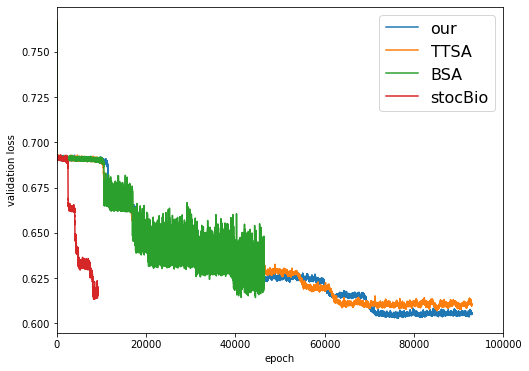

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))#(figsize=(6.4, 5.6))
plt.plot(record_loss_our[::1])
plt.plot(record_loss_hong[::1])
plt.plot(record_loss_wang[::1])
plt.plot(record_loss_stocbio[::1])
plt.legend(["our", "TTSA", "BSA", "stocBio"],fontsize=16)
plt.xlim([0, 100000])
plt.xlabel("epoch")
plt.ylabel("validation loss")
fig.savefig('bilevel_epoch.pdf', bbox_inches='tight', dpi=fig.dpi)

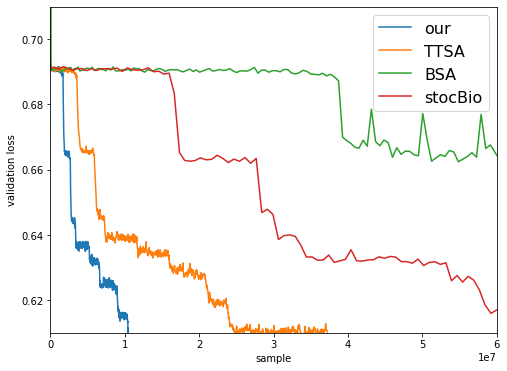

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
sp = 100
plt.plot(record_s_our[::sp], record_loss_our[::sp])
plt.plot(record_s[::sp], record_loss_hong[::sp])
plt.plot(record_s_wang[::sp], record_loss_wang[::sp])
plt.plot(record_s_stocbio[::sp], record_loss_stocbio[::sp])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(["our", "TTSA",  "BSA", "stocBio"], fontsize=16, loc=1)
plt.xlim([0, 6e7])
plt.ylim([0.61, 0.71])
plt.xlabel("sample")
plt.ylabel("validation loss")
fig.savefig('bilevel_sample.pdf', bbox_inches='tight', dpi=fig.dpi)

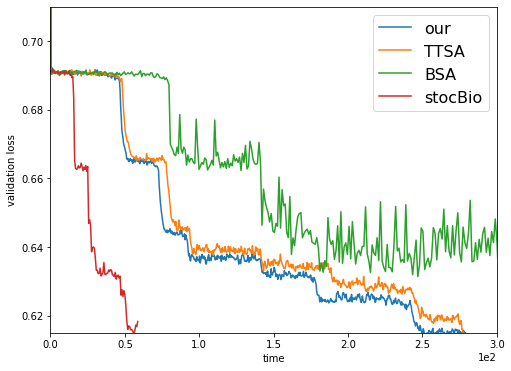

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
sp = 100
plt.plot(record_t_our[::sp], record_loss_our[::sp])
plt.plot(record_t_hong[::sp], record_loss_hong[::sp])
plt.plot(record_t_wang[::sp], record_loss_wang[::sp])
plt.plot(record_t_stocbio[::sp], record_loss_stocbio[::sp])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(["our", "TTSA",  "BSA", "stocBio"], fontsize=16, loc=1)
plt.xlim([0, 3e2])
plt.ylim([0.615, 0.71])
plt.xlabel("time")
plt.ylabel("validation loss")
fig.savefig('bilevel_sample.pdf', bbox_inches='tight', dpi=fig.dpi)

In [528]:
epochmax = 100

In [212]:
print(lam)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [385]:
a = np.linalg.lstsq(np.random.randn(10, 20), np.random.randn(10))[0]
print(a.shape)

(20,)


<ipython-input-385-11817b445ca6>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(np.random.randn(10, 20), np.random.randn(10))[0]


In [429]:
A = np.random.randn(10,10)
A = A + A.T
eigs, eigv = np.linalg.eigh(A)

In [443]:
print(np.linalg.norm(A - (eigv @ (eigs[:, np.newaxis] * eigv.T))))

1.808545579411944e-14


In [167]:
print(lam)

[6.91993102e-02 1.72039780e-02 5.76617137e-02 1.00000000e-04
 6.07397107e-02 1.00000000e-04 8.73258545e-03 1.00000000e-04
 2.23733281e-01 7.45498198e-02 1.15942931e+00 1.82936455e-02
 5.76932617e-02 7.58075206e-02]


In [471]:
print(record_s[-1], record_s_wang[-1])

5879 8599


In [472]:
print(record_loss_hong[-1], record_s_wang[-1])

0.7558248042521697 8599
